<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/demo/notebook/psm_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
!pip install psmpy
!pip install pysmatch
!pip install causalml
!pip install xgboost
!pip install zepid
!pip install rpy2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from causalml import match
from pysmatch.Matcher import Matcher
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
from  xgboost import XGBClassifier
from zepid import (RiskDifference, RiskRatio, OddsRatio, NNT,
                   IncidenceRateRatio, IncidenceRateDifference)
from zepid.superlearner import GLMSL, StepwiseSL, SuperLearner
from zepid.causal.doublyrobust import TMLE, SingleCrossfitAIPTW, SingleCrossfitTMLE
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter 
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import sys
import requests 
import io
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%%R
install.packages("tmle")
install.packages("xgboost")

Check to see if GPU connected. 
It is advised to add GPU from Runtime<Change runtime type<Hardware Accelaration<GPU for faster processing speeds

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importing csv 

In [5]:
url = "https://raw.githubusercontent.com/Jarvis-BITS/midodrine-mimic-iv/demo/data/table_cohort.csv"
download = requests.get(url).content

In [6]:
cohort_table = pd.read_csv(io.StringIO(download.decode('utf-8')))
cohort_table

,stay_id,hadm_id,subject_id,age,Gender,ethnicity,midodrine,avg_doses_per_24_hrs,MICU,adm_weekday,...,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,sedative_use,ventilation_use,vasopressor_use,mortality,mort_28_day,admit_hour
0,36014877,27162817,11861017,87,0,WHITE,1,1.595745,0,1,...,17.600000,36.416667,100.000000,247.375000,1.0,1.0,1,0,0,15
1,32272859,25963696,11259141,60,1,WHITE,1,1.633333,0,7,...,17.333333,36.898333,97.259259,120.200000,1.0,1.0,1,0,0,18
2,34023828,21782431,18010960,59,0,UNKNOWN,1,1.589041,0,1,...,15.392857,36.786667,96.629630,98.000000,1.0,1.0,1,0,0,15
3,37798199,29764966,10926537,42,1,BLACK/AFRICAN AMERICAN,1,1.568627,0,7,...,17.240000,37.142857,99.791667,95.000000,1.0,1.0,1,0,0,17
4,32309766,29272306,15703353,59,1,WHITE,1,1.517241,0,6,...,21.740741,37.372000,98.178571,136.800000,1.0,1.0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35295,39955170,24679700,12799579,55,1,WHITE,0,1.464286,1,7,...,24.148148,37.325000,94.115385,148.333333,0.0,1.0,1,0,0,19
35296,39977793,20968809,13886051,66,1,WHITE,0,1.407407,1,3,...,14.400000,36.646364,97.205882,96.333333,0.0,1.0,1,1,1,19
35297,39980385,21253505,11392990,73,0,WHITE,0,1.592593,1,5,...,19.605263,36.835000,93.605263,203.200000,0.0,1.0,1,1,0,6
35298,39985296,29295929,19632565,59,1,WHITE,0,1.782609,1,2,...,25.692308,36.603333,96.296296,173.400000,0.0,1.0,1,1,1,15


In [33]:
cohort_table.columns

Index(['stay_id', 'hadm_id', 'subject_id', 'age', 'Gender', 'ethnicity',
       'midodrine', 'avg_doses_per_24_hrs', 'MICU', 'adm_weekday', 'weight',
       'sapsii', 'charlson_index', 'CPD_or_COPD_rate', 'Maligancy_rate',
       'mild_liver_rate', 'severe_liver_rate', 'Renal_rate', 'CAD_rate',
       'AFIB_rate', 'hemoglobin', 'platelet', 'wbc', 'sodium', 'potassium',
       'bicarbonate', 'chloride', 'bun', 'creatinine', 'lactate', 'ph', 'po2',
       'pco2', 'bnp', 'troponin', 'creatinine_kinase', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_mean', 'spo2_mean', 'glucose_mean', 'sedative_use',
       'ventilation_use', 'vasopressor_use', 'mortality', 'mort_28_day',
       'admit_hour'],
      dtype='object')

In [34]:
cohort_table.describe()

,stay_id,hadm_id,subject_id,age,Gender,midodrine,avg_doses_per_24_hrs,MICU,adm_weekday,weight,...,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,sedative_use,ventilation_use,vasopressor_use,mortality,mort_28_day,admit_hour
count,3.530000e+04,3.530000e+04,3.530000e+04,35300.000000,35300.000000,35300.000000,35184.000000,35300.000000,35300.000000,34620.000000,...,35235.000000,34986.000000,35214.000000,34326.000000,35113.000000,25512.0,35300.0,35300.000000,35300.000000,35300.000000
mean,3.498390e+07,2.497613e+07,1.499966e+07,62.705694,0.469830,0.022946,1.622051,0.534334,3.992663,80.654058,...,19.282602,36.878330,96.686357,260.224735,0.392647,1.0,1.0,0.172550,0.111841,12.855581
std,2.892380e+06,2.889905e+06,2.887420e+06,18.424232,0.499096,0.149734,0.357446,0.498827,1.995172,26.148795,...,3.934879,0.543675,2.634797,7141.871173,0.488346,0.0,0.0,0.377863,0.315176,7.540701
min,3.000015e+07,2.000035e+07,1.000003e+07,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,6.000000,30.400000,26.600000,34.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000
25%,3.245169e+07,2.247389e+07,1.249361e+07,51.000000,0.000000,0.000000,1.400000,0.000000,2.000000,64.700000,...,16.500000,36.626278,95.542857,107.333333,0.000000,1.0,1.0,0.000000,0.000000,5.000000
50%,3.499433e+07,2.494200e+07,1.501041e+07,64.000000,0.000000,0.000000,1.575000,1.000000,4.000000,77.100000,...,18.653846,36.853333,96.941176,129.000000,0.000000,1.0,1.0,0.000000,0.000000,15.000000
75%,3.748920e+07,2.747473e+07,1.750540e+07,77.000000,1.000000,0.000000,1.794872,1.000000,6.000000,92.300000,...,21.454545,37.135714,98.315789,159.750000,1.000000,1.0,1.0,0.000000,0.000000,19.000000
max,3.999938e+07,2.999962e+07,1.999999e+07,102.000000,1.000000,1.000000,9.250000,1.000000,7.000000,1120.000000,...,48.000000,40.104118,100.000000,999999.000000,1.000000,1.0,1.0,1.000000,1.000000,23.000000


In [35]:
cohort_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35300 entries, 0 to 35299
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stay_id               35300 non-null  int64  
 1   hadm_id               35300 non-null  int64  
 2   subject_id            35300 non-null  int64  
 3   age                   35300 non-null  int64  
 4   Gender                35300 non-null  int64  
 5   ethnicity             35300 non-null  object 
 6   midodrine             35300 non-null  int64  
 7   avg_doses_per_24_hrs  35184 non-null  float64
 8   MICU                  35300 non-null  int64  
 9   adm_weekday           35300 non-null  int64  
 10  weight                34620 non-null  float64
 11  sapsii                26683 non-null  float64
 12  charlson_index        35300 non-null  float64
 13  CPD_or_COPD_rate      35300 non-null  float64
 14  Maligancy_rate        35300 non-null  float64
 15  mild_liver_rate    

In [7]:
cohort_table = cohort_table.drop(columns=['ethnicity','hadm_id','subject_id'])

In [8]:
mido_data = cohort_table.loc[cohort_table['midodrine'] == 1]
nomido_data = cohort_table.loc[cohort_table['midodrine'] == 0]

# Propensity score matching

### First method
For this method, you need to change the source code because it can't deal with the situation that 'age' propensity score equals 1
<br>Methods: make those who equal to 1 '-0.0001'

In [14]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [16]:
psm = PsmPy(cohort_table, treatment='midodrine', indx='stay_id', exclude = ['mortality'])

In [17]:
psm.logistic_ps(balance = True)

ValueError: ignored

In [ ]:
psm.predicted_data

In [ ]:
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

In [ ]:
psm.plot_match(Title='Side by side matched controls', Ylabel='Number of patients', Xlabel= 'Propensity logit', names = ['treatment', 'control'], save=True)

In [ ]:
psm.effect_size_plot(save=False)

In [ ]:
psm.matched_ids

### Second way
For this way, you don't need to worry about the 'age' problem, but you can't get the SMD directly and can't use stay_id for the index

In [70]:
m = Matcher(mido_data, nomido_data, yvar="midodrine", exclude=['stay_id', 'mortality','mort_28_day','avg_doses_per_24_hrs'])

Formula:
midodrine ~ AFIB_rate+CAD_rate+CPD_or_COPD_rate+Gender+MICU+Maligancy_rate+Renal_rate+adm_weekday+admit_hour+age+bicarbonate+bnp+bun+charlson_index+chloride+creatinine+creatinine_kinase+dbp_mean+glucose_mean+heart_rate_mean+hemoglobin+lactate+mbp_mean+mild_liver_rate+pco2+ph+platelet+po2+potassium+resp_rate_mean+sapsii+sbp_mean+sedative_use+severe_liver_rate+sodium+spo2_mean+temperature_mean+troponin+vasopressor_use+ventilation_use+wbc
n majority: 11424
n minority: 487


In [71]:
np.random.seed(20220614)
# Error due to missing data
m.fit_scores(balance=True, nmodels=10,n_jobs = 5,model_type='tree')

This computer has: 2 cores , The workers should be :2
Fitting Models on Balanced Samples , model number :0Fitting Models on Balanced Samples , model number :2

Static column dropped: ventilation_useError: Error evaluating factor: NameError: no data named 'vasopressor_use' found
    Q('midodrine') ~ Q('AFIB_rate')+Q('CAD_rate')+Q('CPD_or_COPD_rate')+Q('Gender')+Q('MICU')+Q('Maligancy_rate')+Q('Renal_rate')+Q('adm_weekday')+Q('admit_hour')+Q('age')+Q('bicarbonate')+Q('bnp')+Q('bun')+Q('charlson_index')+Q('chloride')+Q('creatinine')+Q('creatinine_kinase')+Q('dbp_mean')+Q('glucose_mean')+Q('heart_rate_mean')+Q('hemoglobin')+Q('lactate')+Q('mbp_mean')+Q('mild_liver_rate')+Q('pco2')+Q('ph')+Q('platelet')+Q('po2')+Q('potassium')+Q('resp_rate_mean')+Q('sapsii')+Q('sbp_mean')+Q('sedative_use')+Q('severe_liver_rate')+Q('sodium')+Q('spo2_mean')+Q('temperature_mean')+Q('troponin')+Q('vasopressor_use')+Q('ventilation_use')+Q('wbc')
                                                                   

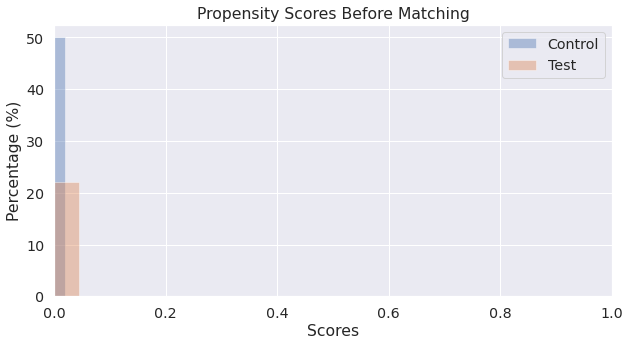

In [43]:
m.predict_scores()
m.plot_scores()

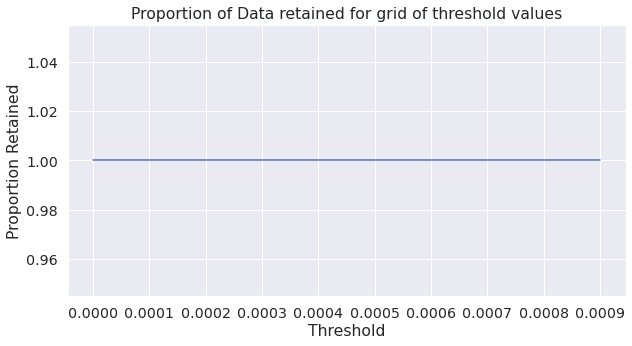

In [44]:
m.tune_threshold(method='random')

In [ ]:
m.match(method="min", nmatches=1, threshold=0.0009)

In [ ]:
m.matched_data.sort_values("match_id")

,AFIB_rate,CAD_rate,CPD_or_COPD_rate,Gender,MICU,Maligancy_rate,Renal_rate,adm_weekday,age,bicarbonate,...,stay_id,temperature_mean,troponin,vasopressor_use,ventilation_use,wbc,weight,scores,match_id,record_id
0,0.0,1.0,0.0,0,1,0.0,0.0,3,91,23.500000,...,30419609,36.805000,1.000000,0,1.0,15.900000,68.7,0.702346,0,0
14874,0.0,0.0,0.0,1,0,0.0,0.0,4,59,27.529412,...,39393117,36.744681,1.000000,1,1.0,6.085714,77.9,0.702349,0,14874
1,0.0,0.0,0.0,0,1,0.0,0.0,5,18,27.000000,...,30905391,37.887143,0.000000,0,0.0,4.650000,67.5,0.797434,1,1
34160,1.0,0.0,0.0,0,0,0.0,0.0,1,91,24.181818,...,38455362,37.308667,1.000000,1,1.0,14.440000,66.0,0.797374,1,34160
2,1.0,1.0,0.0,0,1,0.0,0.0,3,91,18.500000,...,34118048,36.797857,0.000000,1,0.0,10.480000,65.5,0.917741,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14440,1.0,1.0,1.0,0,0,0.0,0.0,4,59,33.611111,...,32935029,37.060182,0.000000,1,1.0,13.006667,116.0,0.804565,807,14440
808,1.0,0.0,0.0,1,1,1.0,1.0,5,91,16.400000,...,38011202,36.657647,1.000000,0,1.0,31.842857,60.0,0.910174,808,808
10294,0.0,0.0,0.0,0,0,0.0,0.0,4,52,22.000000,...,39952814,36.730000,0.000000,1,1.0,15.200000,64.4,0.909980,808,10294
809,1.0,0.0,0.0,1,1,0.0,0.0,5,91,22.181818,...,39446578,36.530370,0.666667,1,1.0,31.280000,63.2,0.804519,809,809


### Third Way

In [61]:
X = cohort_table.drop(['stay_id','mortality', 'mort_28_day', 'midodrine', 'avg_doses_per_24_hrs'], axis=1)
y = cohort_table['midodrine']

In [62]:
from sklearn.model_selection import train_test_split 
seed = 20220614 #for reproducible results
test_size=0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [63]:
from sklearn.metrics import accuracy_score

#instantiate model and train
model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=300)

In [64]:
# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.82%


In [65]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    model = XGBClassifier(n_estimators=300, learning_rate=learning_rate, max_features=2, max_depth=5, random_state=seed)
    model.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(model.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(model.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.987
Accuracy score (validation): 0.978
Learning rate:  0.075
Accuracy score (training): 0.991
Accuracy score (validation): 0.978
Learning rate:  0.1
Accuracy score (training): 0.995
Accuracy score (validation): 0.978
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.978
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.977
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.978
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.978


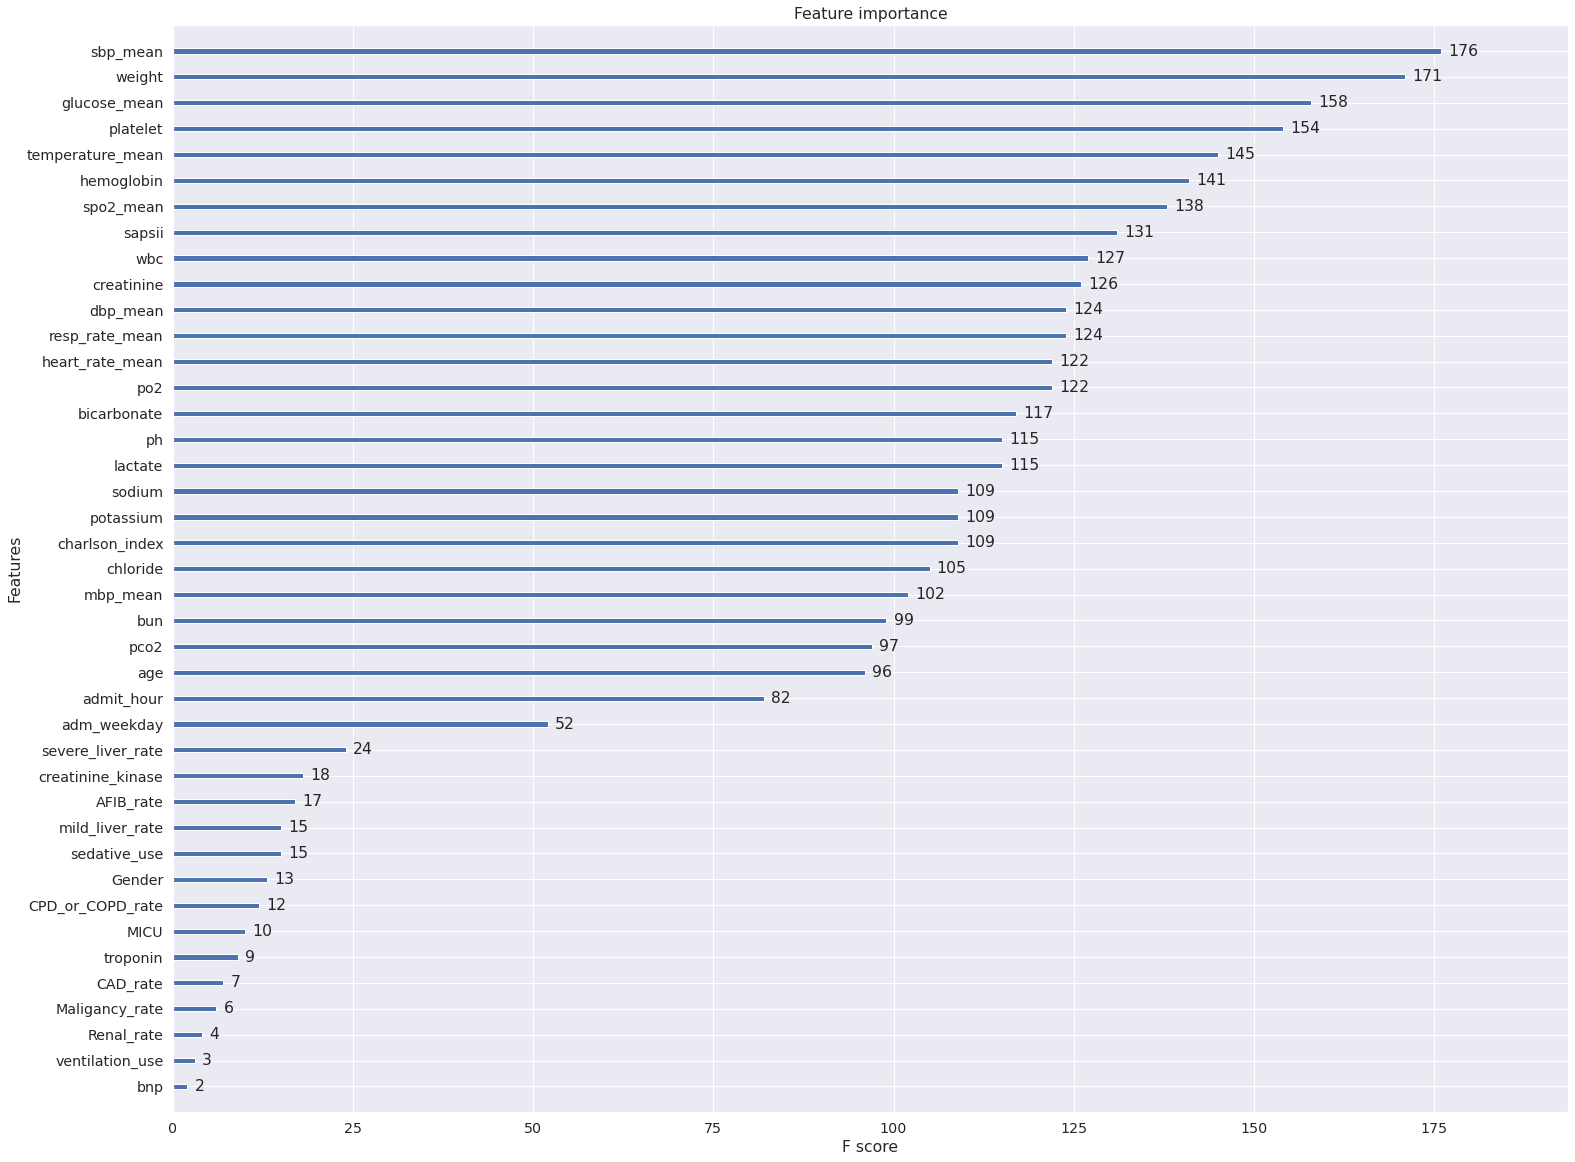

In [66]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
fig, ax = plt.subplots(figsize=(25,20))
plot_importance(model, ax=ax)
plt.show()

## TMLE on unweighted cohort

In [72]:
import statsmodels.api as sm

In [73]:
# SuperLearner setup
labels = ["LogR", "Step.int", "RandFor"]
candidates = [GLMSL(sm.families.family.Binomial()), 
              StepwiseSL(sm.families.family.Binomial(), selection="forward", order_interaction=0),
              XGBClassifier()]

In [76]:
tml =  TMLE(cohort_table, exposure='midodrine', outcome='mort_28_day')

In [77]:
cohort_table.columns

Index(['stay_id', 'age', 'Gender', 'midodrine', 'avg_doses_per_24_hrs', 'MICU',
       'adm_weekday', 'weight', 'sapsii', 'charlson_index', 'CPD_or_COPD_rate',
       'Maligancy_rate', 'mild_liver_rate', 'severe_liver_rate', 'Renal_rate',
       'CAD_rate', 'AFIB_rate', 'hemoglobin', 'platelet', 'wbc', 'sodium',
       'potassium', 'bicarbonate', 'chloride', 'bun', 'creatinine', 'lactate',
       'ph', 'po2', 'pco2', 'bnp', 'troponin', 'creatinine_kinase',
       'heart_rate_mean', 'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_mean', 'spo2_mean', 'glucose_mean', 'sedative_use',
       'ventilation_use', 'vasopressor_use', 'mortality', 'mort_28_day',
       'admit_hour'],
      dtype='object')

In [78]:
tml.exposure_model('age + MICU + Gender + adm_weekday + weight + sapsii + charlson_index + CPD_or_COPD_rate + Maligancy_rate + mild_liver_rate + severe_liver_rate + Renal_rate + CAD_rate + AFIB_rate + hemoglobin + platelet + wbc + sodium + potassium + bicarbonate + chloride + bun + creatinine + lactate + ph + po2 + pco2 + bnp + troponin + creatinine_kinase + temperature_mean + heart_rate_mean + resp_rate_mean + mbp_mean + sedative_use + ventilation_use + vasopressor_use',
                  bound=0.01 )  

Propensity Score Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:              midodrine   No. Observations:                11644
Model:                            GLM   Df Residuals:                    11608
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1555.8
Date:                Wed, 22 Jun 2022   Deviance:                       3111.7
Time:                        06:31:57   Pearson chi2:                 1.30e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept      

In [79]:
tml.outcome_model('age + MICU + Gender + adm_weekday + weight + sapsii + charlson_index + CPD_or_COPD_rate + Maligancy_rate + mild_liver_rate + severe_liver_rate + Renal_rate + CAD_rate + AFIB_rate + hemoglobin + platelet + wbc + sodium + potassium + bicarbonate + chloride + bun + creatinine + lactate + ph + po2 + pco2 + bnp + troponin + creatinine_kinase + temperature_mean + heart_rate_mean + resp_rate_mean + mbp_mean + sedative_use + ventilation_use + vasopressor_use',
                  bound=0.01 )

Outcome Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:            mort_28_day   No. Observations:                11644
Model:                            GLM   Df Residuals:                    11608
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4402.6
Date:                Wed, 22 Jun 2022   Deviance:                       8805.2
Time:                        06:32:28   Pearson chi2:                 1.10e+04
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.

In [80]:
tml.fit() 

In [81]:
tml.summary()

                Targeted Maximum Likelihood Estimator                 
Treatment:        midodrine       No. Observations:     11644               
Outcome:          mort_28_day     No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Q-Model:          Logistic       
Risk Difference:     0.012
95.0% two-sided CI: (-0.033 , 0.057)
----------------------------------------------------------------------
Risk Ratio:          1.067
95.0% two-sided CI: (0.845 , 1.346)
----------------------------------------------------------------------
Odds Ratio:          1.082
95.0% two-sided CI: (0.811 , 1.444)


	Exposure Model Diagnostics
                   Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be 2
----------------------------------------------------------------------
Mean weight:            1.957
Standard Deviation:     7.3
Minimum weight:         1.01
Maximum weight:         100.0

                  Standardized Mean Differences
                          smd_w     smd_u
labels                                   
age               -1.350501e-02 -0.059827
MICU              -8.628047e-02  0.169140
Gender            -7.870642e-02 -0.073722
adm_weekday        4.080462e-02 -0.031428
weight            -9.623617e-02  0.163847
sapsii             1.243305e-01  0.515211
charlson_index     1.960068e-02  0.368102
CPD_or_COPD_rate  -1.969641e-02 -0.082643
Maligancy_rate    -1.740774e-02 -0.058935
mild_liver_rate   -7.318970e-02  0.874871
severe_liver_rate -1.7045

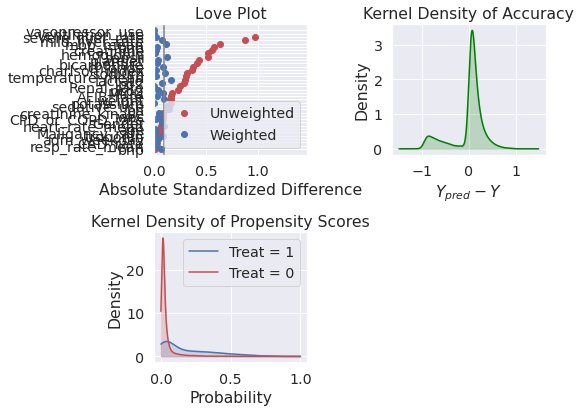

In [82]:
tml.run_diagnostics()

## Weighted cohort using tmle

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(tidyverse)
library(tmle)
library(xgboost)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: glmnet

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Loaded glmnet 4.1-4

R[write to console]: Loading required package: SuperLearner

R[write to console]: Loading required package: nnls

R[write to console]: Loading required package: gam

R[write to console]: Loading required package: splines

R[write to console]: 

In [12]:
%%R
full_data <- read.csv("https://raw.githubusercontent.com/Jarvis-BITS/midodrine-mimic-iv/demo/data/table_cohort.csv")

In [5]:
%%R
class(full_data)

[1] "data.frame"


In [6]:
%%R
as_tibble(full_data)

# A tibble: 35,300 × 50
    stay_id hadm_id subject_id   age Gender ethnicity midodrine avg_doses_per_2…
      <int>   <int>      <int> <int>  <int> <chr>         <int>            <dbl>
 1 36014877  2.72e7   11861017    87      0 WHITE             1             1.60
 2 32272859  2.60e7   11259141    60      1 WHITE             1             1.63
 3 34023828  2.18e7   18010960    59      0 UNKNOWN           1             1.59
 4 37798199  2.98e7   10926537    42      1 BLACK/AF…         1             1.57
 5 32309766  2.93e7   15703353    59      1 WHITE             1             1.52
 6 32470068  2.99e7   12682108    32      1 WHITE             1             1.67
 7 39913468  2.56e7   14695267    26      0 UNKNOWN           1             1.96
 8 36158255  2.69e7   11544355    29      0 UNKNOWN           1             1.69
 9 39406131  2.71e7   16583373    51      0 WHITE             1             1.64
10 38515563  2.42e7   11896370    62      1 WHITE             1             1.37
# … 

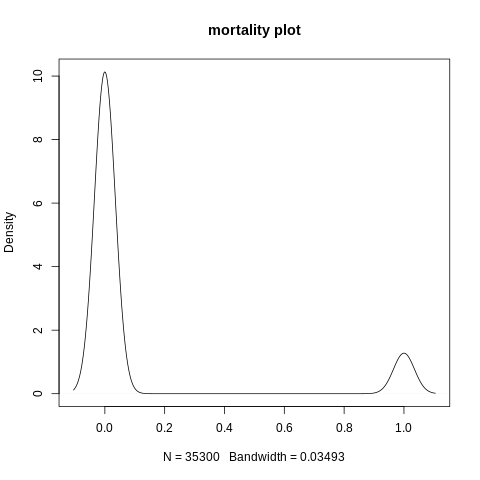

In [81]:
%%R
plot(density(full_data$mort_28_day), main = "mortality plot") #should come out as bionomial

In [13]:
%%R
features = subset(full_data,select=-c(stay_id,hadm_id,subject_id,ethnicity,midodrine,avg_doses_per_24_hrs,mortality,mort_28_day,vasopressor_use))

In [8]:
%%R
str(features)

'data.frame':	35300 obs. of  41 variables:
 $ age              : int  87 60 59 42 59 32 26 29 51 62 ...
 $ Gender           : int  0 1 0 1 1 1 0 0 0 1 ...
 $ MICU             : int  0 0 0 0 0 0 0 0 1 0 ...
 $ adm_weekday      : int  1 7 1 7 6 3 2 7 1 5 ...
 $ weight           : num  70 81.6 90 73 72.7 86.3 81 66.8 62 111 ...
 $ sapsii           : num  42 34 15 30 20 18 38 24 31 23 ...
 $ charlson_index   : num  8.83 3.33 3 2 3 ...
 $ CPD_or_COPD_rate : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Maligancy_rate   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ mild_liver_rate  : num  0 0 0 0 0 0 0 0 1 0 ...
 $ severe_liver_rate: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Renal_rate       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CAD_rate         : num  1 0 0 0 0 0 0 0 0 0 ...
 $ AFIB_rate        : num  0 1 0 0 0 0 0 0 1 0 ...
 $ hemoglobin       : num  10.4 11.2 13.2 12.4 8 ...
 $ platelet         : num  273 238 157 195 223 ...
 $ wbc              : num  11.7 10.6 11.5 12.1 10.2 ...
 $ sodium           : num  136 135 142 140 136 .

In [18]:
%%R
# using colMeans()
mean_val <- colMeans(features,na.rm = TRUE)
  
# replacing NA with mean value of each column
for(i in colnames(features))
  features[,i][is.na(features[,i])] <- mean_val[i]

In [21]:
%%R 
set.seed(20220614)
SL.library = c("SL.glm", "SL.glmnet", "SL.xgboost") # Faster library
g.SL.library <- c("SL.glm", "SL.glmnet", "SL.stepAIC", "SL.bayesGLM", "SL.glm.interaction", "SL.mean", "SL.earth", "SL.gam", "SL.xgboost")
Q.SL.library <- c("SL.glm", "SL.glmnet", "SL.stepAIC", "SL.rpartPrune", "SL.mean")

In [11]:
%%R
colnames(features)

 [1] "age"               "Gender"            "MICU"             
 [4] "adm_weekday"       "weight"            "sapsii"           
 [7] "charlson_index"    "CPD_or_COPD_rate"  "Maligancy_rate"   
[10] "mild_liver_rate"   "severe_liver_rate" "Renal_rate"       
[13] "CAD_rate"          "AFIB_rate"         "hemoglobin"       
[16] "platelet"          "wbc"               "sodium"           
[19] "potassium"         "bicarbonate"       "chloride"         
[22] "bun"               "creatinine"        "lactate"          
[25] "ph"                "po2"               "pco2"             
[28] "bnp"               "troponin"          "creatinine_kinase"
[31] "heart_rate_mean"   "sbp_mean"          "dbp_mean"         
[34] "mbp_mean"          "resp_rate_mean"    "temperature_mean" 
[37] "spo2_mean"         "glucose_mean"      "sedative_use"     
[40] "ventilation_use"   "admit_hour"       


In [22]:
%%R
tmle.fit <- tmle::tmle(Y = full_data$mort_28_day, 
                   A = full_data$midodrine, 
                   W = features,
                   family = "binomial",
                   V = 3,
                   Q.SL.library = SL.library, 
                   g.SL.library = SL.library)

In [23]:
%%R
tmle.fit

 Additive Effect
   Parameter Estimate:  0.016993
   Estimated Variance:  3.6085e-06
              p-value:  <2e-16
    95% Conf Interval: (0.01327, 0.020717) 

 Additive Effect among the Treated
   Parameter Estimate:  0.035811
   Estimated Variance:  0.00024758
              p-value:  0.022852
    95% Conf Interval: (0.0049706, 0.066651) 

 Additive Effect among the Controls
   Parameter Estimate:  -0.088951
   Estimated Variance:  3.4588e-06
              p-value:  <2e-16
    95% Conf Interval: (-0.092596, -0.085306) 

 Relative Risk
   Parameter Estimate:  1.1529
              p-value:  <2e-16
    95% Conf Interval: (1.1169, 1.1901) 

              log(RR):  0.1423
    variance(log(RR)):  0.00026239 

 Odds Ratio
   Parameter Estimate:  1.1754
              p-value:  <2e-16
    95% Conf Interval: (1.1339, 1.2184) 

              log(OR):  0.1616
    variance(log(OR)):  0.00033644 


In [24]:
%%R
summary(tmle.fit)

 Initial estimation of Q
	 Procedure: cv-SuperLearner, ensemble
	 Model:
		 Y ~  SL.glm_All + SL.glmnet_All + SL.xgboost_All

	 Coefficients: 
	      SL.glm_All    0.3244076 
	   SL.glmnet_All    0 
	  SL.xgboost_All    0.6755924 

	 Cross-validated pseudo R squared :  0.2924 

 Estimation of g (treatment mechanism)
	 Procedure: SuperLearner, ensemble	 Empirical AUC = 0.9955 

	 Model:
		 A ~  SL.glm_All + SL.glmnet_All + SL.xgboost_All 

	 Coefficients: 
	      SL.glm_All    0.3162209 
	   SL.glmnet_All    0.2786243 
	  SL.xgboost_All    0.4051549 

 Estimation of g.Z (intermediate variable assignment mechanism)
	 Procedure: No intermediate variable 

 Estimation of g.Delta (missingness mechanism)
	 Procedure: No missingness, ensemble

 Bounds on g: (0.0025, 1) 

 Bounds on g for ATT/ATE: (0.0025, 0.9975) 

 Additive Effect
   Parameter Estimate:  0.016993
   Estimated Variance:  3.6085e-06
              p-value:  <2e-16
    95% Conf Interval: (0.01327, 0.020717) 

 Additive Effect am

In [25]:
%%R
tmle_est_tr <- tmle.fit$estimates$ATE$psi
tmle_est_tr

[1] 0.01699342


## Extract matched no-midodrine data
Here I use the first way

In [ ]:
nomid_matched = table_init[table_init['stay_id'].isin(psm.matched_ids['matched_ID'])]

In [ ]:
nomid_matched.describe()

In [ ]:
nomid_group.describe()

In [ ]:
psm.effect_size

## Save the results

In [ ]:
mid_group.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/mid_group.csv')
nomid_group.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/nomid_group.csv')
nomid_matched.describe().to_csv('/content/drive/MyDrive/midodrine_table1_results/nomid_matched.csv')
psm.effect_size.to_csv('/content/drive/MyDrive/midodrine_table1_results/psm_effect_size.csv')